Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score

Loading the Dataset

In [2]:
# Load COVID-19 confirmed cases dataset
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df = pd.read_csv(url)

# Display first few rows
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


Preprocessing the data

In [3]:
# Select a country (change if needed)
country = "Kenya"
df_country = df[df["Country/Region"] == country].drop(columns=["Province/State", "Lat", "Long"]).sum()

# Convert to time series
df_country = df_country.iloc[1:]  # Remove 'Country/Region' row
df_country.index = pd.to_datetime(df_country.index)  # Convert dates
df_country = df_country.reset_index()
df_country.columns = ["Date", "Confirmed"]

# Add "Days Since First Case" column
df_country["Days"] = (df_country["Date"] - df_country["Date"].min()).dt.days

<ipython-input-3-7ee9f43f9c97>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_country.index = pd.to_datetime(df_country.index)  # Convert dates


Defining our dependent and independent variable

In [4]:
# Define independent (X) and dependent (y) variables
X = df_country[["Days"]].values
y = df_country["Confirmed"].values

Feature Scaling

In [5]:
# Scale X for models that require scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Training individual Regressors

In [6]:
# Polynomial Features
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

# Define Models
linear_reg = LinearRegression()
poly_reg = LinearRegression()
svr = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
decision_tree = DecisionTreeRegressor(max_depth=5)
random_forest = RandomForestRegressor(n_estimators=10, random_state=42)

# Train Models
linear_reg.fit(X_scaled, y)
poly_reg.fit(X_poly, y)
svr.fit(X_scaled, y)
decision_tree.fit(X_scaled, y)
random_forest.fit(X_scaled, y)

# Predictions
y_pred_linear = linear_reg.predict(X_scaled)
y_pred_poly = poly_reg.predict(X_poly)
y_pred_svr = svr.predict(X_scaled)
y_pred_tree = decision_tree.predict(X_scaled)
y_pred_rf = random_forest.predict(X_scaled)


Implementing voting Regressors

In [7]:
# Create Voting Regressor (Using All Models)
voting_regressor = VotingRegressor([
    ("Linear", linear_reg),
    ("Polynomial", poly_reg),
    ("SVR", svr),
    ("Decision Tree", decision_tree),
    ("Random Forest", random_forest)
])

# Train Voting Regressor
voting_regressor.fit(X_scaled, y)

# Make Predictions
y_pred_voting = voting_regressor.predict(X_scaled)


Compare model Performance

In [8]:
# Function to Evaluate Models
def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name}:\n  MSE: {mse:.2f}\n  R² Score: {r2:.4f}\n")

# Evaluate Individual Models
evaluate_model("Linear Regression", y, y_pred_linear)
evaluate_model("Polynomial Regression", y, y_pred_poly)
evaluate_model("SVR", y, y_pred_svr)
evaluate_model("Decision Tree", y, y_pred_tree)
evaluate_model("Random Forest", y, y_pred_rf)

# Evaluate Voting Regressor
evaluate_model("Voting Regressor", y, y_pred_voting)


Linear Regression:
  MSE: 894695795.02
  R² Score: 0.9482

Polynomial Regression:
  MSE: 101443121.12
  R² Score: 0.9941

SVR:
  MSE: 14443844734.30
  R² Score: 0.1638

Decision Tree:
  MSE: 6687822.80
  R² Score: 0.9996

Random Forest:
  MSE: 24776.68
  R² Score: 1.0000

Voting Regressor:
  MSE: 859999758.87
  R² Score: 0.9502



Plotting all models

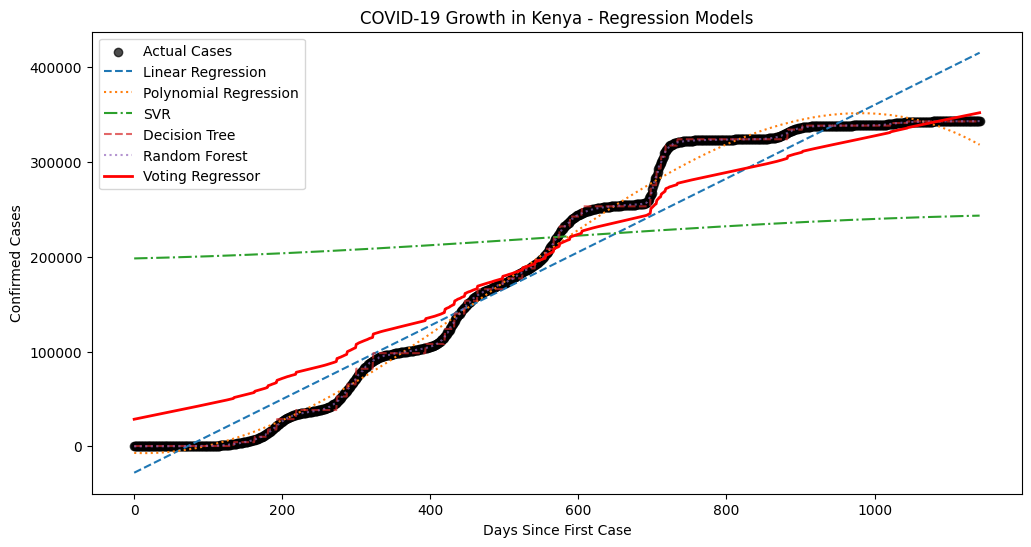

In [9]:
plt.figure(figsize=(12, 6))
plt.scatter(df_country["Days"], df_country["Confirmed"], color="black", label="Actual Cases", alpha=0.7)

plt.plot(df_country["Days"], y_pred_linear, label="Linear Regression", linestyle="dashed")
plt.plot(df_country["Days"], y_pred_poly, label="Polynomial Regression", linestyle="dotted")
plt.plot(df_country["Days"], y_pred_svr, label="SVR", linestyle="dashdot")
plt.plot(df_country["Days"], y_pred_tree, label="Decision Tree", linestyle="dashed", alpha=0.7)
plt.plot(df_country["Days"], y_pred_rf, label="Random Forest", linestyle="dotted", alpha=0.7)
plt.plot(df_country["Days"], y_pred_voting, label="Voting Regressor", color="red", linewidth=2)

plt.xlabel("Days Since First Case")
plt.ylabel("Confirmed Cases")
plt.title(f"COVID-19 Growth in {country} - Regression Models")
plt.legend()
plt.show()
